# NFL Project
This is a (currently incomplete) hobby project for messing around with NFL statistics.

My original intent for this project was to find a way to separate the performance of a wide receiver (WR) from his quarterback (QB) in order to settle frequent debates with firends.  Since the two positions are so closely linked, it can be difficult to determine how good a WR is relative to his peers if he plays with an elite QB, and vice versa.  In order to answer this question, I create a metric to evaluate a WR's and QB's performance relative to the rest of the NFL.

## Running the code
The code is exucuted by running the `calculate_nfl_averages.py` script in the root directory, and it reads inputs from `config/config.cfg`

### Configuration
The code reads in settings from a configuration file located in `config/config.cfg`:
1. Paths: specify the paths to the home directory of the project and the directory where the data is located
2. Config: a list of players to be plotted, specified via their ID that can be looked up in `data/playerIDs.cfg`
3. Metric: here the weights of various stats can be set for calculating the metric

### Outputs
Below is a sample console output from running the code:
```
$ python3 calculate_nfl_averages.py 
Processing play #25000
Processing play #50000
Processing play #75000
Processing play #100000
Processing play #125000
Processing play #150000
Processing play #175000
Processing play #200000
Processing play #225000
Processing play #250000
Processing play #275000
Processing play #300000
Processing play #325000
Finished reading 342276 plays in 9.52 seconds.
Calculating stats for player #1000
Calculating stats for player #2000
Finished calculating stats for 2417 players in 4.48 seconds.
Finished calculating league averages in 0.13 seconds.
Finished calculating metric for all players in 0.61 sec.
Making plots for player 2506106 -- Larry Fitzgerald (WR).
Done in 13.36 sec.
Making plots for player 2503532 -- Hines Ward (WR).
Done in 12.40 sec.
Making plots for player 2505587 -- Anquan Boldin (WR).
Done in 12.72 sec.
```

## Walkthrough of the code
The following subsections will detail the inner workings of the framework as well as a demo using the player Larry Fitzgerald.

In [1]:
# Get all the imports we will need to get this running

# set the path for our local modules
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# local includes
from python.classes import *
from python.stat_minMaxAvg import *
from python.utils import *
# python includes
import numpy as np
from matplotlib import pyplot as plt

### Reading in the data
The input data to the code is a .csv file containing every passing play run in the NFL from 2004-2018. The .csv contains a variety of information about the play, including what game it was, which QB and WR were involved, and what the result of the pass was.  A sample line is below:

In [2]:
with open('data/lfitz.csv') as input_data:
    line = input_data.readline()
    print(line)

3800;2510;2004;Week 1;2505076;Josh McCown;QB;2506106;Larry Fitzgerald;WR;0;complete;1;1;NULL;37;0;0;0;0;0;0;1;37;0;0



The input data is read line-by-line and a `Play` object is created for each line.  The `Play` object simply stores all the information in the play, and each is manually assigned a `play_id` for identification purposes.  For readability, the `Play` class contains a dictionary lookup table so that stats can be requested in using a string rather than an index.

Here we create a `Play` from the line printed above.

In [3]:
example_play = Play(0,line)
print('example_play data:\n{}\n'.format(example_play.to_string()))
print("Retrieve a stat via example_play.get_stat('pass_total_yards'):")
print(example_play.get_stat('pass_total_yards'))

example_play data:
[0, 3800, 2510, 2004, 'Week 1', 2505076, 'Josh McCown', 'QB', 2506106, 'Larry Fitzgerald', 'WR', 0, 'complete', 1, 1, 'NULL', 37, 0, 0, 0, 0, 0, 0, 1, 37, 0, 0]

Retrieve a stat via example_play.get_stat('pass_total_yards'):
37


### Calculating player stats
Each `Play` has two players accociated with it, the 'passer' and the 'receiver'. A `Player` object is created (if it does not already exist) for the passer and receiver, and the `Play` is assigned to both `Player` objects.  When the `Play` is added to the `Player`, it is automatically sorted by year.

The `Player` object calculates the player's combined statistics from the associated `Play` objects using the `calculate()` function. 

In [4]:
plays   = []
players = {}

with open('data/lfitz.csv') as input_data:
    line = input_data.readline()
    line_count = 0
    while line:
        line_count += 1
        play = Play(line_count,line)
        plays.append(play)
        # add play to relevant players, create if necessary
        # only if NOT nullified by penalty and during regular season!
        if (not play.is_nullified()) and (play.is_regular_season()):
            pass_id = play.get_stat('passer_id')
            if not pass_id in players:
                passer = Player()
                passer.set_player(pass_id, 
                                  play.get_stat('passer_name'), 
                                  play.get_stat('passer_pos'))
                passer.add_stat(play)
                players[pass_id] = passer
            else:
                players[pass_id].add_stat(play)

            rec_id = play.get_stat('receiver_id')
            if not rec_id in players:
                receiver = Player()
                receiver.set_player(rec_id, 
                                    play.get_stat('receiver_name'), 
                                    play.get_stat('receiver_pos'))
                receiver.add_stat(play)
                players[rec_id] = receiver
            else:
                players[rec_id].add_stat(play)
            
        if line_count % 500 == 0:
            players[2506106].calculate()
            catches = sum(players[2506106].get_calculated_stat('rec_reception'))
            print('Total receptions after processing {} plays: {}'.format(line_count,catches))

        # next line
        line = input_data.readline()
   
# calculate stats for all players
for p_id in players:
    players[p_id].calculate()

Total receptions after processing 500 plays: 277
Total receptions after processing 1000 plays: 523
Total receptions after processing 1500 plays: 753
Total receptions after processing 2000 plays: 1018


### Calculating league averages
At this point, the code does a lot of work to calculate the NFL-wide averages for each stat.  We will not go into detail here since it is a bit complicated, but essentially a `LeagueAverages` object is created that represents the entire NFL.  Each `Player` is passed to the `LeagueAverages` object, which makes use of the `StatMinMaxAvg` class to calculate the minimum, maximum, and average values of each statistic on a year-by-year basis.  The `StatMinMaxAvg` class automatically updates the calculations each time a `Player` is added.

A minimum number of passes or receptions can be specified such that a player's season stats are only included in the `LeagueAverages` calculation if that minimum is met.

Below is an example of a "mini-league" created from the plays stored earlier.  (Reminder that this only contains plays involving Larry Fitzgerald, and thus will not accurately reflect the real NFL totals.) 

In [5]:
min_rec = 50
min_pass = 10

test_league = LeagueAverages(range(2004,2019),min_rec,min_pass)
for p_id in players:
    test_league.add_player(players[p_id])
    
print('Example league-wide statistics for the 2004 season:\n')
print(test_league.get_calculated_stat('pass_complete')[0].to_string())
print(test_league.get_calculated_stat('pass_total_yards')[0].to_string())

Example league-wide statistics for the 2004 season:

Tracking stat Pass completions -- Total: 56 | Min: 10 | Max: 46 | Avg: 28.0 -- from 2 entries
Tracking stat Pass total yards -- Total: 768 | Min: 129 | Max: 639 | Avg: 384.0 -- from 2 entries


Originally, the framework was going to be broken down into two steps, with the first one calculating all the league averages and writing them to a file to be read in by the second step.  However, since reading and processing the full data set takes under 30 seconds, it is not necessary to do so.

### Plotting player statistics
At this point, we can make plots of a chosen player's statistics vs the league minimum, maximum, and average values.  For this demo, the league stats are manually entered due to insufficient information in the example data set.

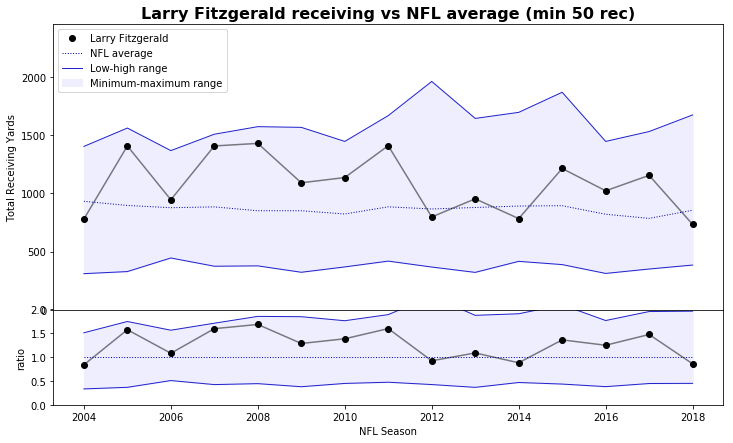

In [7]:
# set up plots
figure = plt.figure(figsize=(12,7))
grid   = plt.GridSpec(8,1,hspace=0)

main_plot  = figure.add_subplot(grid[:6,:],xticklabels=[])
ratio_plot = figure.add_subplot(grid[6:,:])

# get player of interest
this_player  = players[2506106]
player_stats = this_player.get_calculated_stat('rec_total_yards')
player_years = this_player.seasons

# clean player stats -- fill in missing years
clean_stats  = []
years        = range(2004,2019)

for year in years:
    if year not in player_years:
        clean_stats.append(np.NaN)
    else:
        clean_stats.append(player_stats[player_years.index(year)])

# league stats
average = [932.4642857142857, 896.9824561403509, 877.4590163934427, 884.5820895522388, 851.5757575757576, 851.3478260869565, 823.2941176470588, 885.0972222222222, 866.6, 879.4533333333334, 891.7307692307693, 894.8082191780821, 821.3258426966293, 785.8815789473684, 855.6216216216217]
minimum = [310, 328, 445, 374, 377, 322, 368, 418, 367, 321, 416, 388, 312, 350, 384]
maximum = [1405, 1563, 1369, 1510, 1575, 1569, 1448, 1670, 1964, 1646, 1698, 1871, 1448, 1533, 1676]

# get ratio stats
r_clean_stats = divide_lists(clean_stats,average)
r_average = divide_lists(average,average)
r_minimum = divide_lists(minimum,average)
r_maximum = divide_lists(maximum,average)        

#--------------
# MAIN PLOT
#--------------
# player of interest's stats
main_plot.plot(years,clean_stats, color='#010101', linestyle='', marker='o', linewidth=1.5, label="Larry Fitzgerald")
main_plot.plot(years,clean_stats, color='#010101', linestyle='-', linewidth=1.5, alpha=0.5)
# nfl average
main_plot.plot(years,average, color='#000099', linestyle=':', linewidth=1, label="NFL average")
# nfl min/max and fill the area in between
main_plot.plot(years,minimum, color='#2222CC', linestyle='-', linewidth=1, label="Low-high range")
main_plot.plot(years,maximum, color='#2222CC', linestyle='-', linewidth=1, label="_noLabel")
main_plot.fill_between(years,minimum,maximum,color='#EEEEFF', label="Minimum-maximum range")

#--------------
# RATIO PLOT
#--------------
# player of interest's stats
ratio_plot.plot(years,r_clean_stats, color='#010101', marker='o', linestyle='', linewidth=1.5)
ratio_plot.plot(years,r_clean_stats, color='#010101', linestyle='-', linewidth=1.5, alpha=0.5)
# nfl average
ratio_plot.plot(years,r_average, color='#000099', linestyle=':', linewidth=1)
# nfl min/max and fill the area in between
ratio_plot.plot(years,r_minimum, color='#2222CC', linestyle='-', linewidth=1)
ratio_plot.plot(years,r_maximum, color='#2222CC', linestyle='-', linewidth=1)
ratio_plot.fill_between(years,r_minimum,r_maximum,color='#EEEEFF')

# labels and stuff
ratio_plot.set_ylim(0,1.99)
ratio_plot.set_xlabel("NFL Season")
ratio_plot.set_ylabel("ratio")

main_plot.set_ylim(0.1,main_plot.get_ylim()[1]*1.2)
main_plot.set_ylabel("Total Receiving Yards")
main_plot.set_title("Larry Fitzgerald receiving vs NFL average (min 50 rec)", fontsize=16, fontweight='bold')
main_plot.legend(loc='upper left')

plt.show()

In the full framework, plots for the passers who threw to the chosen receiver are also produced. Note that if multiple players threw to the receiver (i.e. due to injury), their stats will be combined.  This sample dataset does not contain enough information to make these plots, so one generated from the full data set is included below.

![](data/2506106_pass_total_yards.png "pass yards")

### Calculating the performance metric
The metric $\mathcal{M}^p$ for player $p$ is calculated as a weighted sum of the $Z$-score of each stat for weights $w_i$:
\begin{equation}
\mathcal{M^p} = \sum\limits_i w_i Z_{i}^{p}
\end{equation}
The $Z$-score for the $i^{\textrm{th}}$ statistic is defined as
\begin{equation}
Z_i^p = \frac{s_i^p - \mu_i}{\sigma_i}
\end{equation}
where $s_i^p$ is the $p$ player's value for the stat, $\mu_i$ is the league average, and $\sigma_i$ is the standard deviation of the stat from all qualifying players. 
The weights are currently chosen by hand, although the original plan was to tune the metric more carefully (if I pick this project back up again, I will do this).

Using this definition for the metric allows it to be easily interpreted.  The $Z$-score is by construction zero for a value equal to the mean, positive (negative) for a value less (greater) than the mean.  As such, a player's metric $\mathcal{M}^p$ will be positive if they were "above average" relative to the entire league.

In the framework, the metric calculation is handled by the `MetricCalculator` object, which can be given a `Player` and a `LeagueAverages` object and returns the metric.  The metric value is then stored in the input objects for later use.

Since this calculation requires the league average information, it cannot be calculated using this small data set.  A plot of Larry Fitzgerald's metric compared to his passers' is shown below:
![](data/2506106_metric.png "metric")

Not losing sight of this project's original intent, which was to try to see if a receiver outplayed his quarterback, the plot above can finally answer that question.  If the metric is tuned properly, the player with the higher value in a given season outperformed the other.  This is illustrated more clearly using the subplot, which shows the difference between the two values.  

In this case, we can conclude that Fitzgerald's impressive career was not simply the result of playing with elite quarterbacks.  In addition, one could expect him to still perform well if he were to switch teams or have a new quarterback.